In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

17224


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 282


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

# Part 2: watershed

In [6]:
for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id < 245:
        continue
        
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_245.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_245.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_245.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.001s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.280s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_245.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '40

-- corrected illumination for channel 750 in 4.207s.
-- corrected illumination for channel 488 in 4.183s.
-- corrected illumination for channel 405 in 4.236s.
- Finished illumination correction in 12.806s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.04 -28.26  -4.32] in 0.554s.
-- drift 1: [  0.07 -27.65  -3.8 ] in 0.567s.
-- drift 2: [  0.03 -28.28  -3.79] in 0.568s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -28.06333333  -3.97      ] for channel: 750
-- finish warpping channel 750 in 16.383s.
-- finish warpping in 16.383s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_248.npy
- run watershed in 81.475s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_248.npy


- Loaded images for channels:['488'] in 1.173s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.082s.
- Finished illumination correction in 1.129s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_252.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.733s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.145s.
-- corrected illuminat

-- drift 0: [ -0.04 -27.32 -14.31] in 0.608s.
-- drift 1: [-2.000e-02 -2.739e+01 -1.418e+01] in 0.550s.
-- drift 2: [  0.   -27.43 -13.98] in 0.627s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.00000000e-02 -2.73800000e+01 -1.41566667e+01] for channel: 750
-- finish warpping channel 750 in 16.290s.
-- finish warpping in 16.290s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_255.npy
- run watershed in 79.804s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_255.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_256.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_256.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sa

-- corrected illumination for channel 488 in 1.067s.
- Finished illumination correction in 1.130s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_259.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.705s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.193s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.175s.
- Finished illumination correction in 12.728s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-1.33333333e-02 -2.83733333e+01 -7.32333333e+00] for channel: 750
-- finish warpping channel 750 in 16.304s.
-- finish warpping in 16.304s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_262.npy
- run watershed in 74.693s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_262.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_263.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_263.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_263.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.028s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 2.676s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.197s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.810s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02 -2.821e+01 -6.590e+00] in 0.566s.
-- drift 1: [-1.000e-02 -2.753e+01 -6.690e+00] in 0.618s.
-- drift 2: [ 1.000e-02 -2.809e+01 -6.260e+00] in 0.580s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

-- finish warpping channel 750 in 16.319s.
-- finish warpping in 16.319s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_269.npy
- run watershed in 76.803s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_269.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_270.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_270.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_270.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.054s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.

- Loaded images for channels:['750', '488', '405'] in 2.636s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.251s.
-- corrected illumination for channel 488 in 4.256s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.851s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -27.45 -24.01] in 0.563s.
-- drift 1: [ 1.000e-02 -2.655e+01 -2.438e+01] in 0.595s.
-- drift 2: [  0.03 -27.37 -23.91] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-

-- warp image with drift:[  0.04333333 -26.85666667  -6.92333333] for channel: 750
-- finish warpping channel 750 in 16.271s.
-- finish warpping in 16.271s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\segmentation_label_276.npy
- run watershed in 79.443s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\Segmentation\watershed\segmentation_label_276.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_277.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H11M12\Conv_zscan_277.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221007-hMTG_hM1_sample3\H0M1\Conv_zscan_277.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.997s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.682s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.315s.
-- corrected illumination for channel 488 in 4.365s.
-- corrected illumination for channel 405 in 4.617s.
- Finished illumination correction in 13.472s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -2.704e+01 -1.471e+01] in 0.691s.
-- drift 1: [  0.   -26.59 -14.65] in 0.580s.
-- drift 2: [  0.3  -27.42 -13.92] in 0.608s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.10666667 

<IPython.core.display.Javascript object>


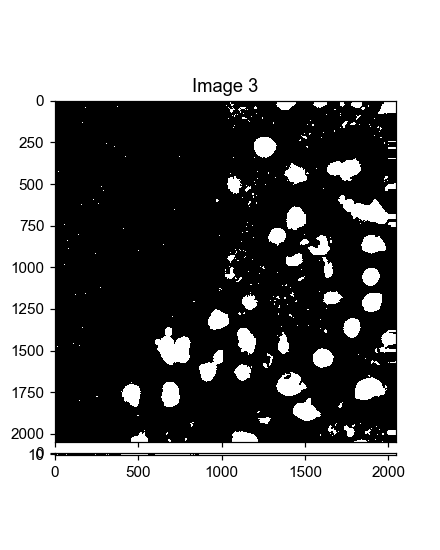

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


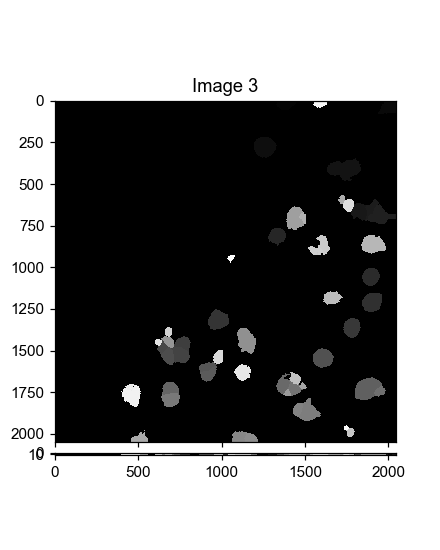

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels])

In [ ]:
wate